In [ ]:
!wget https://data.vision.ee.ethz.ch/cvl/clic/mobile_train_2020.zip
!unzip mobile_train_2020.zip
!wget https://data.vision.ee.ethz.ch/cvl/clic/mobile_valid_2020.zip
!unzip mobile_valid_2020.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
!unzip DIV2K_valid_HR.zip


In [ ]:
import glob
import numpy as np
import cv2
%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.graph_util.extract_sub_graph
import keras
import os
x_valid = np.empty((161,512,768,3)).astype(np.float32)
count = 0
for image_path in glob.glob("../content/valid/*.png"):
    image = cv2.imread(image_path).astype(np.float32)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if (image.shape[0] >= 512 and image.shape[1] >=768):
      image = image[0:0+512, 0:0+768]
      x_valid[count] = image/255
      count+=1
    
for image_path in glob.glob("../content/DIV2K_valid_HR/*.png"):
    image = cv2.imread(image_path).astype(np.float32)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if (image.shape[0] >= 512 and image.shape[1] >=768):
       image = image[0:0+512, 0:0+768]
       x_valid[count] = image/255
       count+=1
x_train = np.empty((1832,512,768,3)).astype(np.float32)
count = 0
for image_path in glob.glob("../content/train/*.png"):
    image = cv2.imread(image_path).astype(np.float32)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if (image.shape[0] >= 512 and image.shape[1] >= 768):
      image = image[0:0+512, 0:0+768]
      x_train[count] = image/255
      count+=1
    
for image_path in glob.glob("../content/DIV2K_train_HR/*.png"):
    image = cv2.imread(image_path).astype(np.float32)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if (image.shape[0] >= 512 and image.shape[1] >= 768):
       image = image[0:0+512, 0:0+768]
       x_train[count] = image/255
       count+=1




TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:

tf.compat.v1.graph_util.extract_sub_graph
from keras.layers import  Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint


input_img = Input(shape=(512, 768, 3))

x = Conv2D(32, [3,3], strides=(1,1), activation="relu")(input_img)
x = Conv2D(32, [3,3], strides=(2,2), activation="relu")(x)
x = Conv2D(64, [3,3], strides=(1,1), activation="relu")(x)
x = Conv2D(64, [3,3], strides=(2,2), activation="relu")(x)
encoded  = Conv2D(32, [3,3], strides=(2,2), activation="relu")(x)
encoder = Model(input_img, encoded)
latentInputs = Input(shape=(62, 94, 32))
y = Conv2DTranspose(32, [3,3], strides= (2,2), activation = "relu")(latentInputs)
y = Conv2DTranspose(64, [3,3], strides= (2,2), activation = "relu")(y)
y = Conv2DTranspose(64, [3,3], strides= (1,1), activation = "relu")(y)
y = Conv2DTranspose(32, [3,3], strides= (2,2), activation = "relu")(y)
y = Conv2DTranspose(32, [3,3], strides= (1,1), activation = "relu")(y)
decoded = Conv2DTranspose(3, [4,4], activation = "relu")(y)
decoder = Model(latentInputs, decoded)

autoencoder = Model(input_img, decoder(encoder(input_img)))
#autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
encoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 768, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 510, 766, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 382, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 252, 380, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 189, 64)      36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 94, 32)        18464     
Total params: 84,032
Trainable params: 84,032
Non-trainable params: 0
_______________________________________________________

In [ ]:
filepath="k_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

H = autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=16,
                shuffle=True,
                validation_data=(x_valid, x_valid),
                callbacks = callbacks_list)


Train on 1832 samples, validate on 161 samples
Epoch 1/25


In [ ]:
a = []
while(1):
    a.append("1")

In [ ]:
encoder.save("encoder_weights.h5")
decoder.save("decoder_weights.h5")

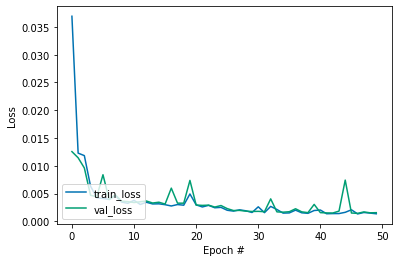

In [ ]:
import matplotlib.pyplot as plt 
N = np.arange(0, 50)
plt.style.use("seaborn-colorblind")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
#plt.title("Training and validation loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")


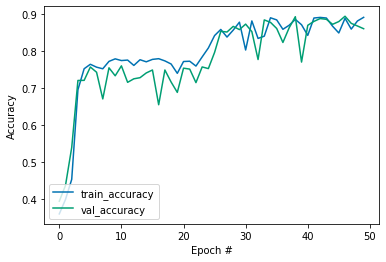

In [ ]:
plt.figure()
plt.plot(N, H.history["accuracy"], label="train_accuracy")
plt.plot(N, H.history["val_accuracy"], label="val_accuracy")
#plt.title("Training and validation accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [ ]:
print(H.history)


{'val_loss': [0.0176780120790249, 0.011271982178946987, 0.009879759711320282, 0.00971512577389596, 0.008865809739857424, 0.010248319688634794, 0.007363219959203337, 0.0038572692800862866, 0.0034471524146492366, 0.0034098617396638043, 0.003080565711391754, 0.003166639131539669, 0.0028666448550390415, 0.002949722134126503, 0.0027374081298342495, 0.002971833022158654, 0.00461008508124801, 0.0027016405947506428, 0.002731232361898559, 0.013871008285977801, 0.0027362240676875, 0.002479580994390073, 0.0029734064763808836, 0.0024313337940600564, 0.0022816382745494608, 0.0025685308462955426, 0.002227462251808067, 0.002387882985144121, 0.0021862580868430804, 0.0021809254750059766, 0.002231209542693906, 0.0027793231801908525, 0.002187895279408234, 0.002251343301604273, 0.0023257321769707515, 0.0021657595701027113, 0.003014650325611478, 0.0021600918157300988, 0.0020526621383843854, 0.0027912618386269103, 0.002005577927119419, 0.001961068204436146, 0.002287270524157364, 0.003630680413764031, 0.0033

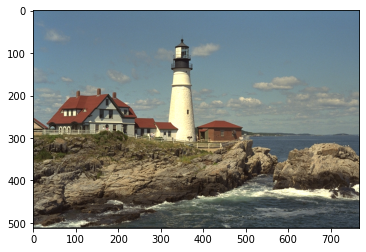

In [ ]:
import imageio
import glob

kodak = np.empty((18, 512, 768, 3)).astype(np.float32)
count = 0
for image_path in glob.glob("../content/*.png"):
    image = cv2.imread(image_path).astype(np.float32)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image[0:0+512, 0:0+768]
    kodak[count] = image/255
    plt.imshow(kodak[count])
    count+=1

    





In [ ]:
decoded_imgs = autoencoder.predict(kodak)

In [ ]:
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

avg_ssim = []
avg_psnr = []
for i in range(18):
  for k in range(10):
    if k==0:
      sum_psnr = psnr(kodak[i], decoded_imgs[i], data_range=None)
    else:
      sum_psnr = sum_psnr + psnr(kodak[i], decoded_imgs[i], data_range=None)
  avg_psnr.append(sum_psnr/10)
  print(avg_psnr[i])

print("ssim")
for i in range(18):
  for k in range(10):
    if k==0:
      sum_ssim = ssim(kodak[i], decoded_imgs[i], multichannel=True)
    else:
      sum_ssim = sum_ssim + ssim(kodak[i], decoded_imgs[i], multichannel=True)
  avg_ssim.append(sum_ssim/10)
  print(avg_ssim[i])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  # This is added back by InteractiveShellApp.init_path()


24.627226541334327
26.790795318826163
21.757173888565944
24.11213960147915
26.13591810443893
24.654816933408906
28.5464706515641
28.96334469649282
29.935989484286
28.00056650771551
23.73726178431655
24.793493838547413
21.83477479316903
25.97114857098032
27.636451719426326
29.234927646952663
26.96625730186244
26.436535052693692
ssim


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


0.903157852504697
0.8847027898087647
0.8233316811789573
0.8560575506556001
0.8673303684317364
0.8457264022298128
0.9450519104108281
0.8980455747102793
0.9548516663021172
0.8911593931710564
0.8139027671224845
0.8714847004972393
0.7661773797982613
0.9147411905443275
0.8947760567733132
0.9316814561592197
0.9276617230900003
0.8996953302276758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


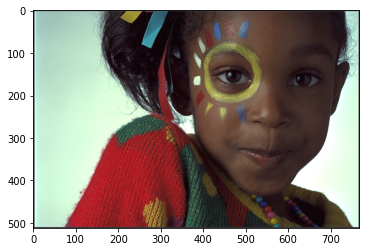

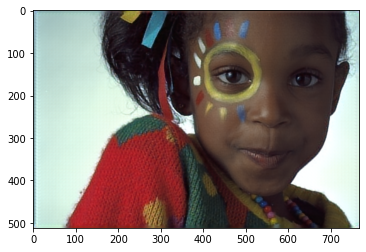

In [ ]:
plt.figure(1)
plt.imshow(kodak[0])
plt.figure(2)
plt.imshow(decoded_imgs[0])